In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 5.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 1.6 MB 55.7 MB/s 
     |████████████████████████████████| 5.8 MB 51.6 MB/s 
     |████████████████████████████████| 438 kB 70.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [2]:
import os
import pandas as pd
import json
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import tensorflow_text as text

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
f = open('/content/drive/MyDrive/data/data_full.json')
data = json.loads(f.read())

##Data exploration

In [5]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [6]:
# create DataFrame
train_data = []
train_class = []
test_data = []
test_class = []
val_data = []
val_class = []

for i in data['train']:
  train_data.append(i[0])
  train_class.append(i[1])

for i in data['test']:
  test_data.append(i[0])
  test_class.append(i[1])

for i in data['val']:
  val_data.append(i[0])
  val_class.append(i[1])


df_train = pd.DataFrame(list(zip(train_data,train_class)),
                        columns = ['text','class'])

df_test = pd.DataFrame(list(zip(test_data,test_class)),
                        columns = ['text','class'])

df_val = pd.DataFrame(list(zip(val_data,val_class)),
                        columns = ['text','class'])

In [7]:
print("Train data size {} \n Test data size {} \n Val data size {}".format(df_train.shape[0],df_test.shape[0],df_val.shape[0]))

Train data size 15000 
 Test data size 4500 
 Val data size 3000


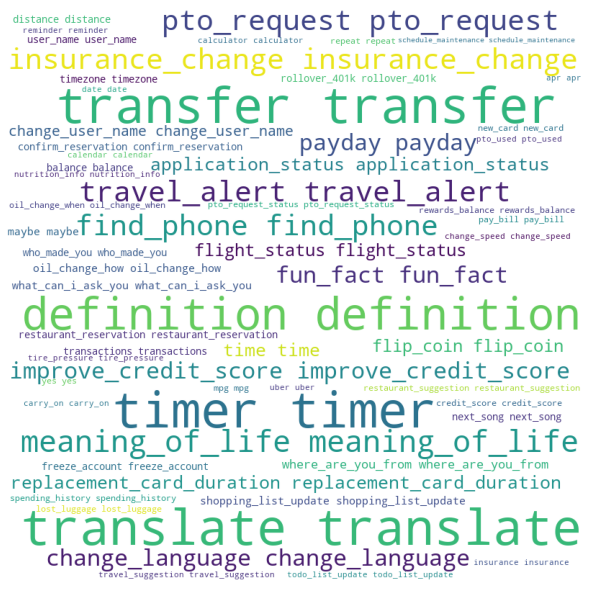

In [8]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_train['class']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Preprocessing

In [9]:
trainlabels=df_train.pop("class")

In [10]:
trainfeatures=df_train.copy()
trainfeatures=trainfeatures.values

In [11]:
from sklearn.preprocessing import LabelBinarizer

In [12]:
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

In [13]:
trainlabels.shape

(15000, 150)

In [14]:
testfeatures=df_test.copy()

In [15]:
testlabels=testfeatures.pop("class")

In [16]:
validfeatures=df_val.copy()

In [17]:
validlabels=validfeatures.pop("class")

In [18]:
testfeatures=testfeatures.values
validfeatures=validfeatures.values

In [19]:
testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

In [20]:
testlabels.shape

(4500, 150)

In [21]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [22]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [23]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2054 3670 2052 1045 2224 2000 2360 1045 2293 2017 2065]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [25]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.35126176  0.006279   -0.99989283  0.29062265  0.21023782 -0.48445597
 -0.76332074 -0.2953436   0.31564564  0.09060848 -0.8633106  -0.2556615 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.11349763 -0.29797176  1.3307792  ... -1.0918118  -0.05384374
  -0.64917034]
 [ 0.26882517 -0.11792442 -1.1042697  ... -0.7519851   0.9297013
  -0.89285487]
 [-0.12542278  0.04376694  0.5652652  ... -0.5828283   0.54959327
  -0.37404943]
 ...
 [-0.72891057 -0.07490081  1.1228836  ... -0.5334061   0.50557494
  -1.0773985 ]
 [-0.45921862 -0.7026323   1.6991307  ... -0.9616932   0.40358156
   0.09007609]
 [-1.878255    0.1746958   1.7472062  ... -1.0660743   1.3269131
  -1.0178112 ]]


In [26]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(150, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [27]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.0055302  0.01764057 0.00202736 0.0097229  0.00909605 0.01281646
  0.00460036 0.0040303  0.01107601 0.00686882 0.00353425 0.01004534
  0.00353647 0.01797279 0.0071781  0.00576941 0.00091079 0.00259255
  0.00942757 0.00983791 0.00734347 0.00664169 0.00405026 0.0041305
  0.00252874 0.00378206 0.00171406 0.00583262 0.00289828 0.00778905
  0.00793403 0.00328997 0.00524488 0.00178655 0.00894938 0.0164792
  0.00187272 0.00298514 0.00333509 0.01755686 0.00662732 0.00420986
  0.00145538 0.00371489 0.01639627 0.00774924 0.00480411 0.0051095
  0.00238571 0.00336264 0.00147026 0.00214738 0.00492955 0.00144657
  0.00266879 0.01170474 0.00221956 0.01339047 0.00554668 0.00080999
  0.00255585 0.01321358 0.00294205 0.01029343 0.00244113 0.00116914
  0.03599343 0.0061806  0.00597795 0.00373403 0.00425712 0.00310849
  0.01136764 0.01302333 0.00250096 0.00204935 0.00495581 0.00301883
  0.00348393 0.01346444 0.01117816 0.00447669 0.01114377 0.01987775
  0.00924835 0.00820583 0.0095859  0.005

In [28]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [29]:
epochs=20
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

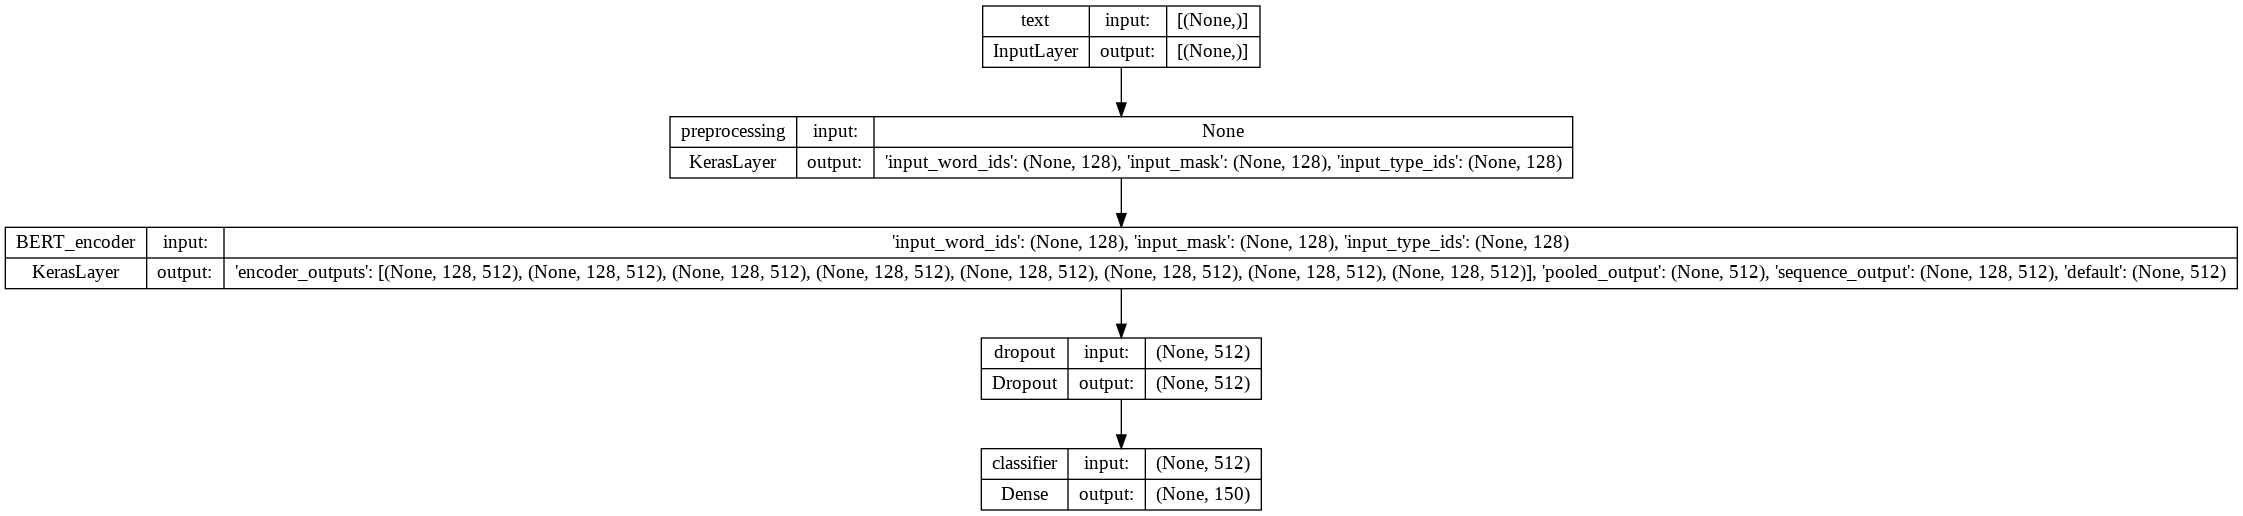

In [30]:

tf.keras.utils.plot_model(classifier_model,show_shapes=True)

In [31]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/20
469/469 [==============================] - 192s 388ms/step - loss: 4.1870 - categorical_accuracy: 0.2073 - val_loss: 2.6960 - val_categorical_accuracy: 0.6207
Epoch 2/20
469/469 [==============================] - 182s 389ms/step - loss: 2.1223 - categorical_accuracy: 0.7399 - val_loss: 1.3079 - val_categorical_accuracy: 0.8297
Epoch 3/20
469/469 [==============================] - 182s 388ms/step - loss: 1.1267 - categorical_accuracy: 0.8765 - val_loss: 0.7588 - val_categorical_accuracy: 0.8893
Epoch 4/20
469/469 [==============================] - 182s 388ms/step - loss: 0.6689 - categorical_accuracy: 0.9298 - val_loss: 0.5155 - val_categorical_accuracy: 0.9207
Epoch 5/20
469/469 [==============================] - 182s 389ms/step - loss: 0.4358 - categorical_accuracy: 0.9541 - val_loss: 0.3923 - val_categorical_accuracy: 0.9357
Epoch 6/20
469/469 [==============================] - 182s

In [32]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

141/141 [==============================] - 21s 148ms/step - loss: 0.2400 - categorical_accuracy: 0.9462
Loss: 0.24001345038414001
Accuracy: 0.9462222456932068


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


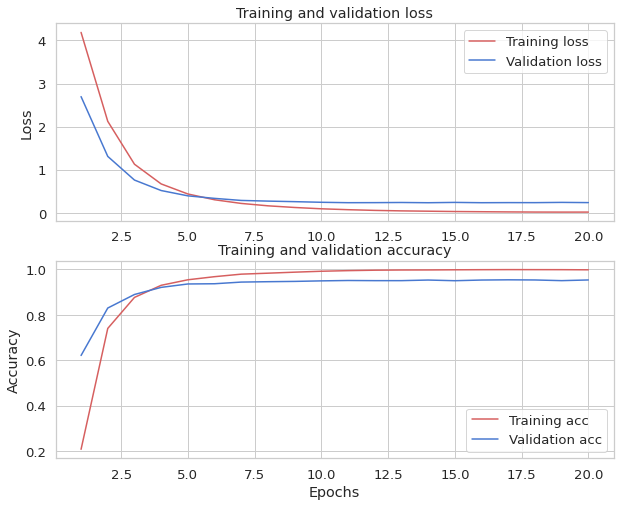

In [33]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [34]:
y_pred = classifier_model.predict(testfeatures)

141/141 [==============================] - 21s 145ms/step


In [35]:
prediction = []
for i in y_pred:
  prediction.append(np.argmax(i))

In [36]:
true = []
for i in testlabels:
  true.append(np.argmax(i))

In [37]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(true, prediction))

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.88      0.97      0.92        30
           2       0.94      1.00      0.97        30
           3       0.97      1.00      0.98        30
           4       0.91      1.00      0.95        30
           5       0.94      1.00      0.97        30
           6       1.00      0.97      0.98        30
           7       0.96      0.80      0.87        30
           8       0.78      0.97      0.87        30
           9       1.00      0.93      0.97        30
          10       1.00      1.00      1.00        30
          11       0.93      0.93      0.93        30
          12       0.92      0.73      0.81        30
          13       0.83      0.97      0.89        30
          14       1.00      1.00      1.00        30
          15       0.91      0.97      0.94        30
          16       1.00      1.00      1.00        30
  

In [38]:
classifier_model.save('/content/drive/MyDrive/data/my_pro_model')